In [1]:
%load_ext autoreload
%autoreload 2
%load_ext yamlmagic

In [2]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Helpful plotting functions
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
import neurite as ne

In [3]:
import universeg
import scribbleprompt
import multiverseg

# Data Loader

In [4]:
from multiverseg.datasets.wbc import WBCDataset
import itertools

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 10

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
print(support_images.shape, support_labels.shape)

torch.Size([10, 1, 128, 128]) torch.Size([10, 1, 128, 128])


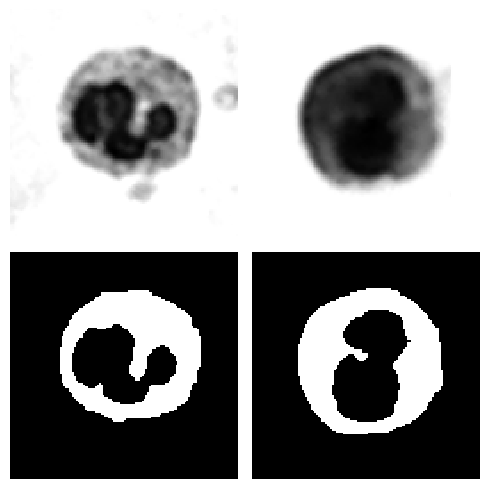

(<Figure size 500x500 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

In [5]:
n = 2
ne.plot.slices(
    [support_images[i].cpu() for i in range(n)]+\
    [support_labels[i].cpu() for i in range(n)],
    grid=(2,n), width=5
)

# Inference Examples

In [6]:
from multiverseg.models.sp_mvs import MultiverSeg

# Instantiate the model
model = MultiverSeg(version="v1")

# Baselines
from universeg import universeg
uvs = universeg(pretrained=True).cuda()

from scribbleprompt.models.unet import ScribblePromptUNet
sp = ScribblePromptUNet(version='v1')

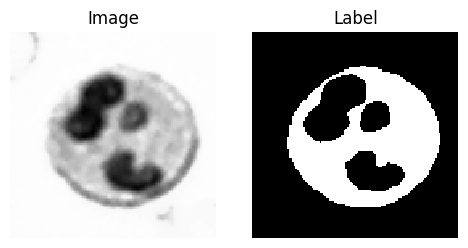

(<Figure size 500x250 with 2 Axes>,
 array([<Axes: title={'center': 'Image'}>,
        <Axes: title={'center': 'Label'}>], dtype=object))

In [7]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

ne.plot.slices([image.cpu(), label.cpu()], width=5, titles=['Image', 'Label'])

## In-Context Segmentation

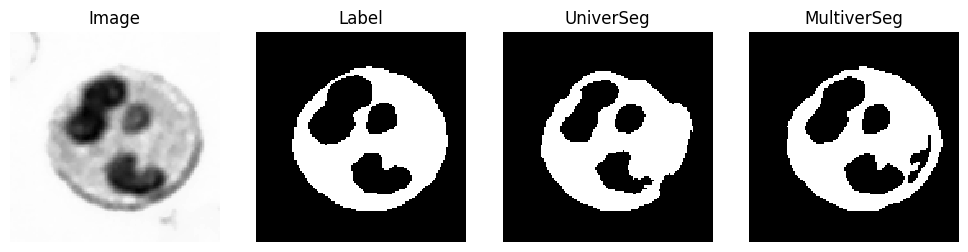

(<Figure size 1000x250 with 4 Axes>,
 array([<Axes: title={'center': 'Image'}>,
        <Axes: title={'center': 'Label'}>,
        <Axes: title={'center': 'UniverSeg'}>,
        <Axes: title={'center': 'MultiverSeg'}>], dtype=object))

In [8]:
# run inference
yhat = model.predict(image[None], support_images[None], support_labels[None], return_logits=False).to('cpu')

# baseline
yhat_uvs = uvs(image[None], support_images[None], support_labels[None]).to('cpu').detach()
yhat_uvs = torch.sigmoid(yhat_uvs).squeeze()

# visualize
ne.plot.slices([image.cpu(), label.cpu(), yhat_uvs > 0.5, yhat > 0.5], width=10, 
               titles=['Image', 'Label', 'UniverSeg', 'MultiverSeg'])

## Interactive Segmentation

In [9]:
%%yaml random_warm_start
_class: scribbleprompt.interactions.prompt_generator.FlexiblePromptEmbed
click_embed:
  _fn: scribbleprompt.interactions.embed.click_onehot
init_pos_click_generators:
    - _class: scribbleprompt.interactions.clicks.RandomClick
      train: False
init_neg_click_generators:
    - _class: scribbleprompt.interactions.clicks.RandomClick
      train: False
correction_click_generators:
  - _class: scribbleprompt.interactions.clicks.ComponentCenterClick
    train: False
init_pos_click: 3
init_neg_click: 3
correction_clicks: 1
prob_bbox: 0.0
prob_click: 1.0
from_logits: True

<IPython.core.display.Javascript object>

In [10]:
from pylot.experiment.util import eval_config
prompt_generator = eval_config(random_warm_start)

In [11]:
prompts = prompt_generator(image[None], label[None])
clicks = {k:prompts.get(k) for k in ['point_coords', 'point_labels']}

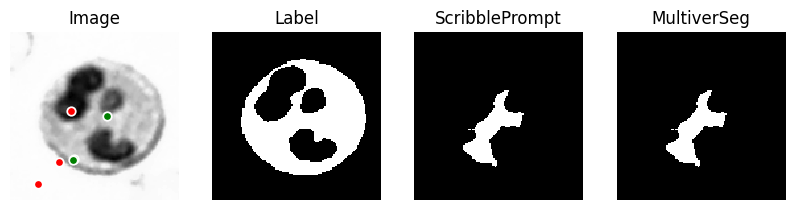

In [12]:
# run inference
yhat = model.predict(image[None], **clicks, return_logits=False).to('cpu')

# baseline
yhat_sp = sp.predict(image[None], **clicks).to('cpu')

# visualize
from scribbleprompt.analysis.plot import show_mask,show_points,show_boxes,show_scribbles
fig,axes = ne.plot.slices([image.cpu(), label.cpu(), yhat_sp > 0.5, yhat > 0.5], width=10, 
               titles=['Image', 'Label', 'ScribblePrompt', 'MultiverSeg'], show=False)
show_points(clicks['point_coords'].cpu(), clicks['point_labels'].cpu(), ax=axes[0])
plt.show()

## Interactive In-Context Segmentation

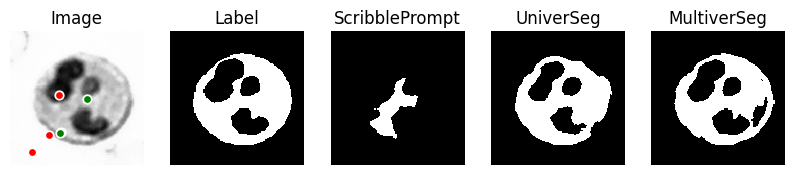

In [13]:
yhat = model.predict(image[None], support_images[None], support_labels[None], **clicks, return_logits=False).to('cpu')

# baseline
yhat_sp = sp.predict(image[None], **clicks).to('cpu')

# visualize
from scribbleprompt.analysis.plot import show_mask,show_points,show_boxes,show_scribbles
fig,axes = ne.plot.slices([image.cpu(), label.cpu(), yhat_sp > 0.5, yhat_uvs > 0.5, yhat > 0.5], width=10, 
               titles=['Image', 'Label', 'ScribblePrompt', 'UniverSeg', 'MultiverSeg'], show=False)
show_points(clicks['point_coords'].cpu(), clicks['point_labels'].cpu(), ax=axes[0])
plt.show()

## Multi-round Inference

In [14]:
# run inference
yhat = model.predict(image[None], support_images[None], support_labels[None], return_logits=True).to('cpu')

# Simulate corrections
corrections = prompt_generator.subsequent_prompt(
    # to use as an input to the model in the next iteration
    mask_pred = yhat.cuda(),
    # to use for calculating error region & sampling interactions
    binary_mask_pred = (yhat.cuda()>0).int(),
    prev_input = prompts
)
correction_clicks = {k:prompts.get(k) for k in ['point_coords', 'point_labels', 'mask_input']}

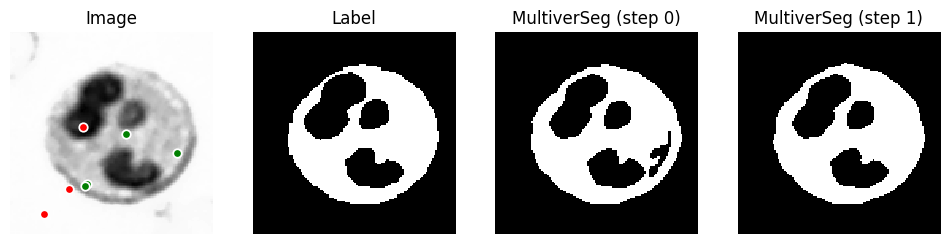

In [15]:
# Run inference
yhat2 = model.predict(image[None], support_images[None], support_labels[None], **correction_clicks, return_logits=False).to('cpu')

# visualize
from scribbleprompt.analysis.plot import show_mask,show_points,show_boxes,show_scribbles
fig,axes = ne.plot.slices([image.cpu(), label.cpu(), yhat > 0.0, yhat2 > 0.5], width=12, 
               titles=['Image', 'Label', 'MultiverSeg (step 0)', 'MultiverSeg (step 1)'], show=False)
show_points(correction_clicks['point_coords'].cpu(), correction_clicks['point_labels'].cpu(), ax=axes[0])
plt.show()